# Complete code of SAR ATR

#  Importing necessary libraries and module


In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os

# Define the Pretext Model architecture

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Concatenate, Lambda
from tensorflow.keras.models import Model

def build_pretext_model(num_classes=11):
    input_shape = (224, 224, 3)
    input_layer = Input(shape=input_shape)

    # -------------------------
    # 1. Resize inside Lambda
    # -------------------------
    resized_input = Lambda(lambda x: tf.image.resize(x, (368, 368)))(input_layer)

    # -------------------------
    # 2. Sobel edges
    # -------------------------
    frost_filter = Lambda(lambda x: tf.image.sobel_edges(x))(resized_input)
    # Shape: (batch, 368, 368, 3, 2)

    # -------------------------
    # 3. Gradient magnitude
    # -------------------------
    multi_scale_features = Lambda(
        lambda x: tf.sqrt(tf.square(x[..., 0]) + tf.square(x[..., 1]))
    )(frost_filter)
    # Shape: (batch, 368, 368, 3)

    # -------------------------
    # 4. Multi-scale conv branches
    # -------------------------
    conv_branch_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(multi_scale_features)
    conv_branch_1 = MaxPooling2D((2, 2))(conv_branch_1)

    conv_branch_2 = Conv2D(64, (5, 5), activation='relu', padding='same')(multi_scale_features)
    conv_branch_2 = MaxPooling2D((2, 2))(conv_branch_2)

    conv_branch_3 = Conv2D(64, (7, 7), activation='relu', padding='same')(multi_scale_features)
    conv_branch_3 = MaxPooling2D((2, 2))(conv_branch_3)

    # -------------------------
    # 5. Concatenate features
    # -------------------------
    concatenated_features = Concatenate()([conv_branch_1, conv_branch_2, conv_branch_3])

    # -------------------------
    # 6. Dense layers for multi-scale output
    # -------------------------
    x = Flatten()(concatenated_features)
    x = Dense(128, activation='relu')(x)
    multi_scale_output = Dense(64, activation='relu')(x)

    # -------------------------
    # 7. Orientation branch
    # -------------------------
    orientation_branch = Conv2D(64, (3, 3), activation='relu', padding='same')(concatenated_features)
    orientation_branch = MaxPooling2D((2, 2))(orientation_branch)
    orientation_branch = Flatten()(orientation_branch)
    orientation_branch = Dense(64, activation='relu')(orientation_branch)

    # -------------------------
    # 8. Concatenate outputs and final layer
    # -------------------------
    concatenated_outputs = Concatenate()([multi_scale_output, orientation_branch])
    final_output = Dense(num_classes, activation='softmax', name='pretext_final')(concatenated_outputs)

    # -------------------------
    # 9. Define model
    # -------------------------
    model = Model(inputs=input_layer, outputs=final_output)
    return model


# Prepare the dataset for training

In [23]:
unlabeled_data_dir =r"C:\Users\Lohith\Desktop\Project\Project\Unlabeled\Unlabeled images"
image_files = [os.path.join(unlabeled_data_dir, filename) for filename in os.listdir(unlabeled_data_dir) if filename.endswith(('.jpg', '.jpeg', '.png'))]
np.random.shuffle(image_files)


# Train the Pretext Model

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
import os

# -------------------------
# 0. Define or load model
# -------------------------
input_layer = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
output_layer = Dense(4, activation='softmax')(x)

pretext_model = Model(inputs=input_layer, outputs=output_layer)

# -------------------------
# 1. Compile model
# -------------------------
pretext_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -------------------------
# 2. Prepare data
# -------------------------
# Replace with your folder containing images
image_dir = r"C:\Users\Lohith\Desktop\Project\Project\Unlabeled\Unlabeled images"

if not os.path.exists(image_dir):
    raise FileNotFoundError(f"Directory not found: {image_dir}")

# Collect image files
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir)
               if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if len(image_files) == 0:
    raise ValueError(f"No image files found in {image_dir}. Please check your dataset.")

num_samples = len(image_files)
print(f" Found {num_samples} images in {image_dir}")

# Create random labels for self-supervised pretext task
random_labels = np.random.randint(0, 4, size=num_samples)
random_labels_onehot = tf.keras.utils.to_categorical(random_labels, num_classes=4)

# -------------------------
# 3. Training loop
# -------------------------
batch_size = 32
epochs = 10

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    epoch_loss = 0
    num_batches = 0

    # Shuffle images each epoch
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    image_files = [image_files[i] for i in indices]
    random_labels_onehot = random_labels_onehot[indices]

    for i in range(0, num_samples, batch_size):
        batch_files = image_files[i:i + batch_size]
        batch_labels = random_labels_onehot[i:i + batch_size]

        if len(batch_files) == 0:
            continue

        # Load and preprocess images
        batch_images = []
        for file in batch_files:
            try:
                img = load_img(file, target_size=(224, 224))
                img_array = img_to_array(img) / 255.0
                batch_images.append(img_array)
            except Exception as e:
                print(f" Could not load image {file}: {e}")

        if len(batch_images) == 0:
            continue

        batch_images = np.array(batch_images)

        # Train on batch
        loss = pretext_model.train_on_batch(batch_images, batch_labels)
        if isinstance(loss, list):
            loss = loss[0]  # Take only the scalar loss
        epoch_loss += loss
        num_batches += 1

    if num_batches > 0:
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch + 1} Average Loss: {avg_loss:.4f}")
    else:
        print(" No batches processed this epoch.")

# -------------------------
# 4. Save weights
# -------------------------
weights_path = 'self_supervised_model_weights.weights.h5'
pretext_model.save_weights(weights_path)
print(f" Pretext model weights saved successfully at {weights_path}")


 Found 2360 images in C:\Users\Lohith\Desktop\Project\Project\Unlabeled\Unlabeled images

Epoch 1/10
Epoch 1 Average Loss: 2.0572

Epoch 2/10
Epoch 2 Average Loss: 1.5249

Epoch 3/10
Epoch 3 Average Loss: 1.4664

Epoch 4/10
Epoch 4 Average Loss: 1.4410

Epoch 5/10
Epoch 5 Average Loss: 1.4184

Epoch 6/10
Epoch 6 Average Loss: 1.3726

Epoch 7/10
Epoch 7 Average Loss: 1.3035

Epoch 8/10
Epoch 8 Average Loss: 1.2242

Epoch 9/10
Epoch 9 Average Loss: 1.1420

Epoch 10/10
Epoch 10 Average Loss: 1.0596
 Pretext model weights saved successfully at self_supervised_model_weights.weights.h5


# Downstream Model

# Importing the libraries

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np


# Loading the pretrained self-supervised model and define the downstream model architecture

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

num_classes = 11

# -------------------------
# 1. Downstream CNN model
# -------------------------
downstream_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),

    Dense(num_classes, activation='softmax')
])

# -------------------------
# 2. Compile model
# -------------------------
downstream_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

downstream_model.summary()


c:\Users\Lohith\Desktop\Project\Project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,445,451 (74.18 MB)

 Trainable params: 19,445,451 (74.18 MB)

 Non-trainable params: 0 (0.00 B)

# Compile the downstream model with specified optimizer and loss function

In [27]:
downstream_learning_rate = 0.001

downstream_model.compile(
    optimizer=Adam(learning_rate=downstream_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Training and testing loop

In [28]:
train_data_dir = r"C:\Users\Lohith\Desktop\Project\Project\Changed\train"
test_data_dir = r"C:\Users\Lohith\Desktop\Project\Project\Changed\test"
batch_size = 32

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

downstream_model.save('model2.h5')

Found 4110 images belonging to 11 classes.
Found 1650 images belonging to 11 classes.


# Set up callbacks for model training

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('downstream_model_weights.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)


#  Train the downstream model

In [30]:
history = downstream_model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[checkpoint, early_stopping]
)


c:\Users\Lohith\Desktop\Project\Project\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 864ms/step - accuracy: 0.2156 - loss: 2.1051

129/129 ━━━━━━━━━━━━━━━━━━━━ 130s 953ms/step - accuracy: 0.3582 - loss: 1.6829 - val_accuracy: 0.6752 - val_loss: 0.9603
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7373 - loss: 0.7227

129/129 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.7873 - loss: 0.5851 - val_accuracy: 0.7630 - val_loss: 0.6252
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.8929 - loss: 0.2820

129/129 ━━━━━━━━━━━━━━━━━━━━ 129s 998ms/step - accuracy: 0.9265 - loss: 0.2132 - val_accuracy: 0.9048 - val_loss: 0.2870
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.9674 - loss: 0.0917

129/129 ━━━━━━━━━━━━━━━━━━━━ 116s 897ms/step - accuracy: 0.9703 - loss: 0.0914 - val_accuracy: 0.9667 - val_loss: 0.0883
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 934s 7s/step - accuracy: 0.9835 - loss: 0.0527 - val_accuracy: 0.9703 - val_loss: 0.0883
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.9848 - loss: 0.0442

129/129 ━━━━━━━━━━━━━━━━━━━━ 114s 887ms/step - accuracy: 0.9842 - loss: 0.0460 - val_accuracy: 0.9812 - val_loss: 0.0666
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.9788 - loss: 0.0597 - val_accuracy: 0.9685 - val_loss: 0.0838
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.9945 - loss: 0.0267

129/129 ━━━━━━━━━━━━━━━━━━━━ 115s 895ms/step - accuracy: 0.9949 - loss: 0.0209 - val_accuracy: 0.9903 - val_loss: 0.0251
Epoch 9/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 115s 891ms/step - accuracy: 0.9961 - loss: 0.0173 - val_accuracy: 0.9873 - val_loss: 0.0319
Epoch 10/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.9973 - loss: 0.0090 - val_accuracy: 0.9885 - val_loss: 0.0494


#  Plot training and testing accuracy curves, ROC curve, and Confusion Matrix

52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step
Classification Report:
              precision    recall  f1-score   support

         2S1       1.00      0.97      0.99       150
        BMP2       0.99      0.97      0.98       150
       BRDM2       0.96      0.98      0.97       150
       BTR60       0.95      0.99      0.97       150
       BTR70       1.00      0.97      0.98       150
          D7       1.00      1.00      1.00       150
       SLICY       0.98      1.00      0.99       150
         T62       1.00      1.00      1.00       150
         T72       0.99      0.99      0.99       150
      ZIL131       1.00      1.00      1.00       150
    ZSU_23_4       1.00      1.00      1.00       150

    accuracy                           0.99      1650
   macro avg       0.99      0.99      0.99      1650
weighted avg       0.99      0.99      0.99      1650



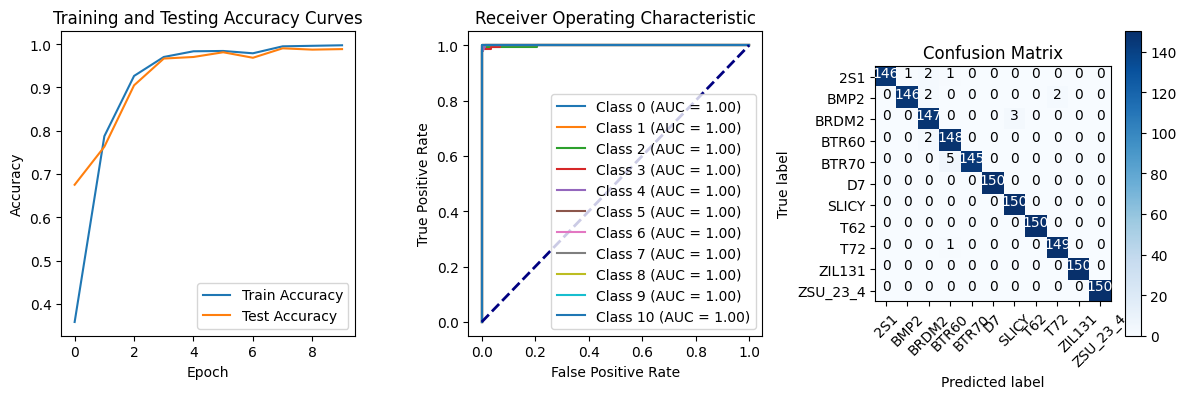

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report



plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Training and Testing Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot ROC curve
plt.subplot(1, 3, 2)
y_true = test_generator.classes
y_scores = downstream_model.predict(test_generator)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Plot Confusion Matrix
plt.subplot(1, 3, 3)
y_pred = downstream_model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Print classification report with F1 score details
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

plt.tight_layout()

plt.show()


# Checking the model is predicting the Image exact or not 

In [ ]:
# Preprocessing the image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess an image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Path to the image you want to test
image_path = r"C:\Users\Lohith\Desktop\Project\Project\Changed\validation\BRDM2\HB15056.jpeg"
# Preprocess the image
input_image = preprocess_image(image_path)


In [41]:
# Get predictions from both models
pretext_predictions = pretext_model.predict(input_image)
downstream_predictions = downstream_model.predict(input_image)

# Get the class labels
pretext_class = np.argmax(pretext_predictions)
downstream_class = np.argmax(downstream_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Text(0.5, 1.0, 'Original Image')

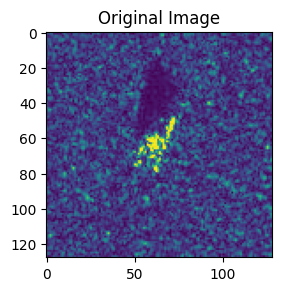

In [42]:
# Load and display the original image
original_image = plt.imread(image_path)
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')


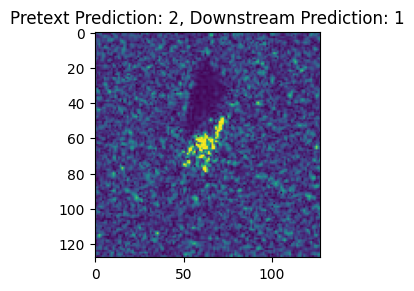

In [43]:
# Display the image with predicted labels
predicted_image = plt.imread(image_path)  # You can modify this line to overlay labels on the original image
plt.subplot(1, 2, 2)
plt.imshow(predicted_image)
plt.title(f'Pretext Prediction: {pretext_class}, Downstream Prediction: {downstream_class}')

plt.show()
